In [20]:
import boto3
import torch
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io

boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
ssm_client = boto3.client("ssm")

s3_bucket = ssm_client.get_parameter(Name="MonaiOnSagemakerBucketParameter")["Parameter"]["Value"]
region = boto_session.region_name
bucket = s3_bucket
prefix = 'monai-async-inference-brain-tumor'
sm_role = ssm_client.get_parameter(Name="MonaiOnSagemakerRoleParameter")["Parameter"]["Value"]
role = sm_role

print(region)
print(role)
print(bucket)
print(prefix)

eu-west-1
arn:aws:iam::617011600974:role/MonaiOnSagemakerInfrastru-MonaiOnSagemakerRoleA19D-1QZWJMQNJ5369
monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp
monai-async-inference-brain-tumor


In [21]:
# Prepare tar package to be consumed by Sagemaker Async Inference
# as an alternative to training here we're not creating a custom docker image but instead
# we're giving to sagenaker a base image managed by AWS for inference and telling to sagemaker to add 
# to the base image tghe libs included in the classic requirements.txt

# Here we should 
# - Get the trained model from S3
# - unpack the pht file into the model folder


s3_trained_model_uri = "s3://monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp/monai-on-sagemaker-training-container-2022-06-11-09-23-37-712/output/model.tar.gz"
from sagemaker.s3 import S3Downloader
S3Downloader.download(s3_trained_model_uri, "./model")

!tar --directory ./model -xvf ./model/model.tar.gz model.pth 

model.pth


In [23]:
!mkdir model_and_code
!cp ./model/model.pth model_and_code/
!mkdir model_and_code/code
!cp ./source/* model_and_code/code
!tar cvzf model.tar.gz -C model_and_code/ . 

from sagemaker.s3 import S3Uploader

# upload packaged model, inference code and requiremts file for lobs to S3
file_key = 'model.tar.gz'
model_artifact = S3Uploader.upload(file_key,'s3://{}/{}/model'.format(bucket, prefix))
print(model_artifact)


#Upload sample dataset to S3
file_key = 'datasets/BRATS_001.nii.gz'
data_artifact = S3Uploader.upload(file_key,'s3://{}/{}/datasets'.format(bucket, prefix))
print(data_artifact)

!rm model.tar.gz


mkdir: cannot create directory ‘model_and_code’: File exists
mkdir: cannot create directory ‘model_and_code/code’: File exists
cp: omitting directory ‘./source/__pycache__’
./
./model.pth
./code/
./code/inference.py
./code/requirements.txt
./code/__init__.py
s3://monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp/monai-async-inference-brain-tumor/model/model.tar.gz
s3://monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp/monai-async-inference-brain-tumor/datasets/BRATS_001.nii.gz


In [24]:
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.g4dn.xlarge'
pytorch_inference_image_uri = retrieve('pytorch',
                                       region,
                                       version='1.11.0',
                                       py_version='py38',
                                       instance_type = deploy_instance_type,
                                       accelerator_type=None,
                                       image_scope='inference')

print(pytorch_inference_image_uri)

763104351884.dkr.ecr.eu-west-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38


In [25]:
container = pytorch_inference_image_uri
model_name = 'sagemaker-monai-brain-tumor-{0}'.format(str(int(time.time())))
print(container)
print(model_name)

763104351884.dkr.ecr.eu-west-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38
sagemaker-monai-brain-tumor-1654950683


In [26]:
create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '200000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '200000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

In [27]:
print(model_name)
endpoint_config_name = f"monaiEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ]
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

sagemaker-monai-brain-tumor-1654950683
Created EndpointConfig: arn:aws:sagemaker:eu-west-1:617011600974:endpoint-config/monaiendpointconfig-2022-06-11-12-31-29


In [28]:
# Async Inference with Sagemaker

bucket_prefix = "monai-async-inference"
resource_name = "Monai-AsyncInferenceDemo-SNS"


In [29]:
response = sns_client.create_topic(Name="Monai-Async-Demo-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

arn:aws:sns:eu-west-1:617011600974:Monai-Async-Demo-ErrorTopic


In [30]:
response = sns_client.create_topic(Name="Monai-Async-Demo-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)


arn:aws:sns:eu-west-1:617011600974:Monai-Async-Demo-SuccessTopic


In [31]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

[{'TopicArn': 'arn:aws:sns:eu-west-1:617011600974:AmazonRekognitionECGAlert'}, {'TopicArn': 'arn:aws:sns:eu-west-1:617011600974:BCDataBrewAtena'}, {'TopicArn': 'arn:aws:sns:eu-west-1:617011600974:Monai-Async-Demo-ErrorTopic'}, {'TopicArn': 'arn:aws:sns:eu-west-1:617011600974:Monai-Async-Demo-SuccessTopic'}]


In [221]:
#Note: Replace with your email id

# email_id = 'your-email@domain-name.com'
# email_sub_1 = sns_client.subscribe(
#     TopicArn=success_topic,
#     Protocol='email',
#     Endpoint=email_id)

# email_sub_2 = sns_client.subscribe(
#     TopicArn=error_topic,
#     Protocol='email',
#     Endpoint=email_id)

#Note: You will need to confirm by clicking on the email you recieve to complete the subscription

In [32]:
print(model_name)
endpoint_config_name = f"Monai-AsyncEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{bucket_prefix}/output",
            #  Optionally specify Amazon SNS topics
            "NotificationConfig": {
              "SuccessTopic": success_topic,
              "ErrorTopic": error_topic,
            }
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 2
        }
    }
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

sagemaker-monai-brain-tumor-1654950683
Created EndpointConfig: arn:aws:sagemaker:eu-west-1:617011600974:endpoint-config/monai-asyncendpointconfig-2022-06-11-12-31-42


In [33]:
endpoint_name = f"monai-async-sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:eu-west-1:617011600974:endpoint/monai-async-sm-2022-06-11-12-31-45


In [34]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


In [36]:
s3_uri = data_artifact
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=s3_uri)
sagemaker_async_output_location = response['OutputLocation']
print(f"OutputLocation: {sagemaker_async_output_location}")



OutputLocation: s3://monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp/monai-async-inference/output/6053522c-eaa0-41c6-9f82-4c28707bf0b6.out


monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp
monai-async-inference/output/6053522c-eaa0-41c6-9f82-4c28707bf0b6.out
Prediction data shape :  (1, 3, 240, 240, 155)


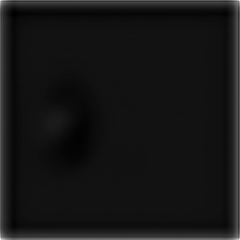

In [46]:

import botocore
import numpy as np
from PIL import Image

s3_output_uri = sagemaker_async_output_location

output_url = urllib.parse.urlparse(s3_output_uri)
bucket = output_url.netloc
key = output_url.path[1:]

print(bucket)
print(key)
s3 = boto3.resource('s3')

try:
    s3.Bucket(bucket).download_file(key, 'prediction.numpy')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
         print("The object does not exist.")
    else:
        raise
prediction_data = np.load("prediction.numpy")
print("Prediction data shape : ", prediction_data.shape)
#test_img = (prediction_data[0,0,:,:,0]).astype(np.uint8)

prediction_img = np.interp(
    prediction_data[0,0,:,:,0],
    (
        prediction_data[0,0,:,:,0].min(), 
        prediction_data[0,0,:,:,0].max() 
    ),
    (0,255)
).astype(np.uint8)

img = Image.fromarray(prediction_img)
# img.save()
img.show()

!rm prediction.numpy



In [38]:
# Trigger 10 asynchronous requests on a single instance
inferences = []
for i in range(1,10):
    start = time.time()
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=s3_uri)
    output_location = response["OutputLocation"]
    inferences += [(s3_uri, output_location)]
    time.sleep(0.5)
print("\Async invocations for Pytorch serving default: \n")

\Async invocations for Pytorch serving default: 



In [39]:
# Enable Autoscaling
client = boto3.client('application-autoscaling') # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id='endpoint/' + endpoint_name + '/variant/' + 'variant1' # This is the format in which application autoscaling references the endpoint

response = client.register_scalable_target(
    ServiceNamespace='sagemaker', 
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=0,  
    MaxCapacity=5
)

response = client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5.0, # The target value for the metric. 
        'CustomizedMetricSpecification': {
            'MetricName': 'ApproximateBacklogSizePerInstance',
            'Namespace': 'AWS/SageMaker',
            'Dimensions': [
                {'Name': 'EndpointName', 'Value': endpoint_name }
            ],
            'Statistic': 'Average',
        },
        'ScaleInCooldown': 120, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                # additional instances before the effects of previous activities are visible. 
                                # You can configure the length of time based on your instance startup time or other application needs.
                                # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
        'ScaleOutCooldown': 120 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled. 
                            # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    }
)

In [40]:
print(response)

{'PolicyARN': 'arn:aws:autoscaling:eu-west-1:617011600974:scalingPolicy:cd64bf86-3cce-4a33-9d23-5853c6d22a1e:resource/sagemaker/endpoint/monai-async-sm-2022-06-11-12-31-45/variant/variant1:policyName/Invocations-ScalingPolicy', 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/monai-async-sm-2022-06-11-12-31-45/variant/variant1-AlarmHigh-ffe724c1-2e8e-4ae0-a957-a49c8c309096', 'AlarmARN': 'arn:aws:cloudwatch:eu-west-1:617011600974:alarm:TargetTracking-endpoint/monai-async-sm-2022-06-11-12-31-45/variant/variant1-AlarmHigh-ffe724c1-2e8e-4ae0-a957-a49c8c309096'}, {'AlarmName': 'TargetTracking-endpoint/monai-async-sm-2022-06-11-12-31-45/variant/variant1-AlarmLow-3db41702-c10b-4514-8574-936bcd49093f', 'AlarmARN': 'arn:aws:cloudwatch:eu-west-1:617011600974:alarm:TargetTracking-endpoint/monai-async-sm-2022-06-11-12-31-45/variant/variant1-AlarmLow-3db41702-c10b-4514-8574-936bcd49093f'}], 'ResponseMetadata': {'RequestId': 'e4d8db21-fb05-4594-81e2-d5f8147a81ab', 'HTTPStatusCode': 200, 'HTTPHeader

In [41]:
print(endpoint_name)
for i in range(1,1000):
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=s3_uri)
print("\Async invocations for Pytorch serving with auotscaling \n")

monai-async-sm-2022-06-11-12-31-45
\Async invocations for Pytorch serving with auotscaling 



In [42]:
import pandas as pd
cw = boto3.Session().client("cloudwatch")

In [43]:
import datetime
from datetime import datetime,timedelta
def get_sagemaker_metrics(endpoint_name,
                          endpoint_config_name,
                          variant_name,
                          metric_name,
                          statistic,
                          start_time,
                          end_time):
    dimensions = [
        {
            "Name": "EndpointName",
            "Value": endpoint_name
        },
        {
            "Name": "VariantName",
            "Value": variant_name
        }
    ]
    if endpoint_config_name is not None:
        dimensions.append({
            "Name": "EndpointConfigName",
            "Value": endpoint_config_name
        })
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions
    )
    rename = endpoint_config_name if endpoint_config_name is not None else 'ALL'
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop(["Unit"], axis=1)\
            .rename(columns={statistic: rename})

def plot_endpoint_model_latency_metrics(endpoint_name, endpoint_config_name, variant_name, start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metric_name = "ModelLatency"
    statistic = "Average"
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name, 
        statistic,
        start_time,
        end_time)
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

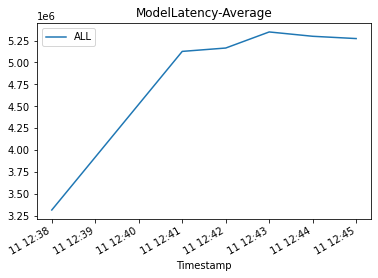

In [44]:
model_latency_metrics = plot_endpoint_model_latency_metrics(endpoint_name, None, "variant1")